# FIT3139 Final Project

## Learning outcomes

1.  Explain and apply the process of computational scientific model building, verification and interpretation
2.  Analyse the differences between core classes of modelling approaches (Numerical versus Analytical; Linear versus Non-linear; Continuous versus Discrete; Deterministic versus Stochastic)
3.   Evaluate the implications of choosing different modelling approaches;
4.   Rationalise the role of simulation and data visualisation in science;
5.   Apply all of the above to solving idealisations of real-world problems across various scientific disciplines.

## Specification table
|||
|------------|---|
| Base Model | Tennis simulation |
| Extension assumpion | Simulate a complete season based on skill distribution |
| Techniques showcaed | Markov chains, montecarlo simulations |
| Modelling question 1 |  |
| Modelling question 2 | |

## Section 2: Introduction

### Identify the problem

The primary problem addressed in this project is to understand the impact of skill distribution on player rankings in a tennis season. Additionally, the project aims to determine whether longer matches or longer seasons are more effective in revealing the true quality of players.

### Motivation behind the problem

This problem is motivated by the need to ensure fairness and accuracy in competitive sports, where ranking systems often determine players' career opportunities, financial rewards, and public recognition.


### Describe the extension and the questions my model will answer

I'm simulating a tennis match using markov chains. The extension is to simulate a complete season based on skill distribution. The base model discussed earlier used markov chain with "some" probability to move to a next point, which didn't take into account the skill level of a player. This extension will simplify the states in the transition matrix but will add complexity to take into account the player's serving and returning skills. The model will answer the following questions:

1. How does the skill distribution of players affect the outcome of a tennis tournament?
2. Comparing initial skill distribution vs point distribution at the end of the tournament.
3. What is more effective in revealing the true quality of players: longer matches or longer tournaments?


### The rules of tennis
#### Points:
Each game starts with a serve and players alternate serving every game. Points are scored as follows: 0 (Love), 15, 30, 40, and game point.

#### Games:
A player wins a game by scoring four points and leading by at least two points. If the score reaches 40-40, the game is in deuce, and a player must win two consecutive points to win the game.

#### Sets:
A player wins a set by winning six games and leading by at least two games. If the score reaches 6-6, a tiebreaker is played to determine the winner of the set.

#### Match:
A player wins a match by winning the best of three or five sets.



## Section 3: Model description


### Model extension details

### Model assumptions

### Class of the model

### Algorithms being used


### Transition matrix example
In my markov chain model, the transition matrix is a 5x5 matrix with the following states/structure:

S1: Serve
S2: Return
S3: Rally
S4: Point won by server
S5: Point won by returner

The transition matrix is as follows:

|   | S1 | S2 | S3 | S4 | S5 |
|---| ---| ---| ---| ---| ---|
| S1 | 0 | 0.5 | 0.5 | 0 | 0 |
| S2 | 0.5 | 0 | 0.5 | 0 | 0 |
| S3 | 0.5 | 0.5 | 0 | 0 | 0 |
| S4 | 0 | 0 | 0 | 0.9 | 0.1 |
| S5 | 0 | 0 | 0 | 0.1 | 0.9 |

## Section 4: Results

### Interpret and analyse my results

### How I arrived at my results


## Section 5: List of algorithms and concepts

### Markov chains - how it plays a role in my model

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [93]:
def proportional_scaling(arr, max_val=1.0):
    arr = np.array(arr)
    total = np.sum(arr)
    if total == 0:
        return arr
    # return [max_val * x / total for x in arr]
    return max_val * arr / total

@dataclass
class Player:
    Serve: float
    Return: float
    sets: int = 0
    games: int = 0
    score: int = 0

    def __setitem__(self, key, value):
        setattr(self, key, value)

    def __getitem__(self, item):
        return getattr(self, item)

In [140]:
def create_transition_matrix(server_skill: int, returner_skill: int):
    # Ensure skills are between 0 and 1
    server_skill = np.clip(server_skill, 0, 1)
    returner_skill = np.clip(returner_skill, 0, 1)
    
    # Probabilities of success for each action
    p_return_success = returner_skill
    p_serve_win_direct = 1 - returner_skill
    p_serve_loss_direct = 1 - server_skill

    # Probabilities of failure for each action
    p_rally_continue = 1 - np.max([server_skill, returner_skill])
    p_server_win = 1 - returner_skill
    p_returner_win = 1 - server_skill
    p_rally_server_win = 1 - returner_skill
    p_rally_returner_win = 1 - server_skill
    
    # p_server_win, p_returner_win = proportional_scaling([server_skill, returner_skill], p_rally_continue)
    # p_rally_server_win, p_rally_returner_win = proportional_scaling([p_server_win, p_returner_win], p_rally_continue)
  
    
    # Transition matrix
    transition_matrix = np.array([
        proportional_scaling([0.0, p_return_success, 0.0, p_serve_win_direct, p_serve_loss_direct]),  # Serve
        proportional_scaling([0.0, 0.0, p_rally_continue, p_server_win, p_returner_win]), # Return
        proportional_scaling([0.0, 0.0, p_rally_continue, p_rally_server_win, p_rally_returner_win ]), # Rally
        [0.0, 0.0, 0.0, 1.0, 0.0],   # Point Won by Server (Terminal)
        [0.0, 0.0, 0.0, 0.0, 1.0]    # Point Won by Returner (Terminal)
    ])
    
    return transition_matrix

# Example usage:
server_skill = 0.8  # High skill server
returner_skill = 0.4  # Moderate skill returner

transition_matrix = create_transition_matrix(server_skill, returner_skill)
print(transition_matrix)


[[0.         0.33333333 0.         0.5        0.16666667]
 [0.         0.         0.2        0.6        0.2       ]
 [0.         0.         0.2        0.6        0.2       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


In [115]:
states = ["Serve", "Return", "Rally", "Point Won by Server", "Point Won by Returner"]

def simulate_point(transition_matrix, initial_state=0):
    current_state = initial_state
    while current_state < 3:
        current_state = np.random.choice(range(5), p=transition_matrix[current_state])
    return current_state

def simulate_game(player1, player2, transition_matrices, current_server=None):
    player1["score"] = 0
    player2["score"] = 0
    current_server = np.random.choice([0, 1]) if current_server is None else current_server
    while True:
        current_server = 1 - current_server
        winner = simulate_point(transition_matrices[current_server])
        if current_server == 0:
            player1["score"] += 1 if winner == 3 else 0
            player2["score"] += 1 if winner == 4 else 0
        else:
            player1["score"] += 1 if winner == 4 else 0
            player2["score"] += 1 if winner == 3 else 0
        
        if player1["score"] >= 4 and player1["score"] >= player2["score"] + 2:
            break
        if player2["score"] >= 4 and player2["score"] >= player1["score"] + 2:
            break
            

    return player1["score"], player2["score"]

def simulate_set(player1, player2, transition_matrices):
    player1["games"] = 0
    player2["games"] = 0
    while True:
        score = simulate_game(player1, player2, transition_matrices)
        winner = 0 if score[0] > score[1] else 1
        player1["games"] += 1 if winner == 0 else 0
        player2["games"] += 1 if winner == 1 else 0
        
        # if 6 all, play tiebreak
        if player1["games"] == 6 and player2["games"] == 6:
            score = simulate_game(player1, player2, transition_matrices, current_server=winner)
            winner = 0 if score[0] > score[1] else 1
            player1["games"] += 1 if winner == 0 else 0
            player2["games"] += 1 if winner == 1 else 0
            break

        if player1["games"] >= 6 and player1["games"] >= player2["games"] + 2:
            break
        if player2["games"] >= 6 and player2["games"] >= player1["games"] + 2:
            break

    return player1["games"], player2["games"]

def simulate_match(player1, player2, transition_matrices, best_of=3):
    player1["sets"] = 0
    player2["sets"] = 0
    required_sets = (best_of + 1) // 2

    while True:
        score = simulate_set(player1, player2, transition_matrices)
        winner = 0 if score[0] > score[1] else 1
        player1["sets"] += 1 if winner == 0 else 0
        player2["sets"] += 1 if winner == 1 else 0

        if player1["sets"] >= required_sets:
            break
        if player2["sets"] >= required_sets:
            break

    return player1["sets"], player2["sets"]
        

In [116]:
player1 = {
    "Serve": 0.7,
    "Return": 0.8
}

player2 = {
    "Serve": 0.9,
    "Return": 0.4
}

transition_matrices = [
    create_transition_matrix(player1["Serve"], player2["Return"]),
    create_transition_matrix(player2["Serve"], player1["Return"])
]

simulate_match(player1, player2, transition_matrices)        


(1, 2)

In [134]:
class SingleEliminationTournament:
    def __init__(self, players, best_of=3):
        self.players = players
        self.best_of = best_of
        self.results = None

    def simulate_round(self):
        winners = []
        for i in range(0, len(self.results), 2):
            player1, player2 = self.results[i], self.results[i + 1]
            transition_matrices = [
                create_transition_matrix(player1.Serve, player2.Return),
                create_transition_matrix(player2.Serve, player1.Return)
            ]
            winner = simulate_match(player1, player2, transition_matrices, best_of=self.best_of)
            winners.append(self.results[i] if winner[0] > winner[1] else self.results[i + 1])
        self.results = winners
    
    def simulate(self):
        self.results = self.players
        while len(self.results) > 1:
            self.simulate_round()
        print(self.results)

players = [
    Player(0.7, 0.8),
    Player(0.9, 0.4),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
]

tournament = SingleEliminationTournament(players, best_of=3)
tournament.simulate()

[Player(Serve=0.7, Return=0.8, sets=2, games=6, score=4)]


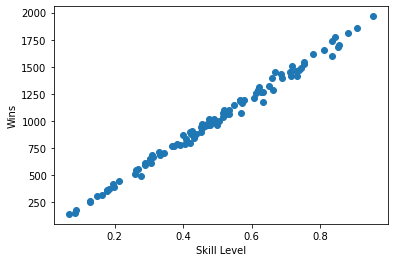

In [98]:
# Montecarlo simulation
# let the skill level of the players be server + return / 2

simulations = 100000
players = []
for _ in range(100):
    player = {
        "Serve": np.random.random(),
        "Return": np.random.random()
    }
    players.append(player)

player_skill_level = [(p["Serve"] + p["Return"]) / 2 for p in players]
# player skill level determines the probability of winning a point
# plot a histogram showing which player won the most points

winners = []
for _ in range(simulations):
    winner = np.random.choice(range(100), p=proportional_scaling(player_skill_level))
    winners.append(winner)

# plot skill level vs number of wins
plt.scatter(player_skill_level, [winners.count(i) for i in range(100)])
plt.xlabel("Skill Level")
plt.ylabel("Wins")
plt.show()

In [99]:
# Define simulation parameters
num_simulations = 1000
best_of = 3

# Run Monte Carlo simulations
results = [0,0]
for _ in range(num_simulations):
    player1 = {
        "Serve": 0.7,
        "Return": 0.8
    }

    player2 = {
        "Serve": 0.9,
        "Return": 0.4
    }
    score = simulate_match(player1, player2, transition_matrices, best_of=best_of)
    results[0] += 1 if score[0] > score[1] else 0
    results[1] += 1 if score[1] > score[0] else 0

# Analyze results
print("Player 1 wins:", results[0])
print("Player 2 wins:", results[1])

Player 1 wins: 527
Player 2 wins: 473


In [100]:
# Define the transition matrix
# transition_matrix = np.array([
#     [0.0, 0.6, 0.0, 0.2, 0.2],   # Serve
#     [0.0, 0.0, 0.7, 0.15, 0.15], # Return
#     [0.0, 0.0, 0.5, 0.25, 0.25], # Rally
#     [0.0, 0.0, 0.0, 1.0, 0.0],   # Point Won by Server (Absorbing)
#     [0.0, 0.0, 0.0, 0.0, 1.0]    # Point Won by Returner (Absorbing)
# ])



# transition_matrix = create_transition_matrix(0.8, 0.7)

# Define the states
states = ["Serve", "Return", "Rally", "Point Won by Server", "Point Won by Returner"]

# Function to simulate a single point
def simulate_point():
    current_state = 0  # Every point starts with a serve
    while current_state not in [3, 4]:  # Until point is won
        # States 3/4 are absorbing states since the probability of transitioning to any other state is 0
        current_state = np.random.choice([0, 1, 2, 3, 4], p=transition_matrix[current_state])
    return current_state

# Function to simulate a game
def simulate_game():
    server_points = 0
    returner_points = 0
    while True:
        result = simulate_point()
        if result == 3:
            server_points += 1
        else:
            returner_points += 1
        
        if server_points >= 4 and server_points - returner_points >= 2:
            return "Server"
        elif returner_points >= 4 and returner_points - server_points >= 2:
            return "Returner"

# Function to simulate a set
def simulate_set():
    server_games = 0
    returner_games = 0
    while True:
        winner = simulate_game()
        if winner == "Server":
            server_games += 1
        else:
            returner_games += 1
        
        if server_games >= 6 and server_games - returner_games >= 2:
            return "Server"
        elif returner_games >= 6 and returner_games - server_games >= 2:
            return "Returner"

# Function to simulate a match (best of 3 sets or best of 5 sets)
def simulate_match(best_of=3):
    server_sets = 0
    returner_sets = 0
    required_sets_to_win = best_of // 2 + 1
    while server_sets < required_sets_to_win and returner_sets < required_sets_to_win:
        winner = simulate_set()
        if winner == "Server":
            server_sets += 1
        else:
            returner_sets += 1
    return "Server" if server_sets == required_sets_to_win else "Returner"


simulate_match(3)

# # Function to simulate a season
# def simulate_season(players, matches_per_player, best_of=3):
#     results = {player: 0 for player in players}
#     for i, server in enumerate(players):
#         for j, returner in enumerate(players):
#             if i != j:
#                 for _ in range(matches_per_player):
#                     winner = simulate_match(best_of=best_of)
#                     if winner == "Server":
#                         results[server] += 1
#                     else:
#                         results[returner] += 1
#     return results

# players = ["Player_1", "Player_2", "Player_3", "Player_4", "Player_5"]
# simulate_season(players, 10, 3)

# # Generate initial skill distribution
# num_players = 10
# initial_skills = np.random.rand(num_players)
# players = {f"Player_{i+1}": skill for i, skill in enumerate(initial_skills)}

# # Simulate seasons and compare results
# def compare_seasons(num_seasons, matches_per_player, best_of_list):
#     season_results = {best_of: [] for best_of in best_of_list}
    
#     for best_of in best_of_list:
#         for _ in range(num_seasons):
#             season_result = simulate_season(players, matches_per_player, best_of)
#             season_results[best_of].append(season_result)
    
#     return season_results

# # Parameters
# num_seasons = 100
# matches_per_player = 10
# best_of_list = [3, 5]

# # Compare seasons
# season_results = compare_seasons(num_seasons, matches_per_player, best_of_list)




# # Analyze the results
# import pandas as pd

# # Convert results to DataFrame
# def results_to_dataframe(results):
#     data = []
#     for season_result in results:
#         for player, points in season_result.items():
#             data.append([player, points])
#     df = pd.DataFrame(data, columns=["Player", "Points"])
#     return df

# df_3_sets = results_to_dataframe(season_results[3])
# df_5_sets = results_to_dataframe(season_results[5])

# # Display the results
# print("Season Results for Best of 3 Sets:")
# print(df_3_sets.groupby("Player").mean().sort_values(by="Points", ascending=False))

# print("\nSeason Results for Best of 5 Sets:")
# print(df_5_sets.groupby("Player").mean().sort_values(by="Points", ascending=False))


'Server'

## Collapse

In [101]:
p = 0.5
M = np.array([
    [0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (0, 0)- 0
    [0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (15, 0)- 1
    [0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (0, 15)- 2
    [0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (30, 0)- 3
    [0, 0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0], # (15, 15)- 4
    [0, 0, 0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0], # (0, 30)- 5
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1-p, 0, p, 0, 0, 0, 0], # (40, 0)- 6
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 0, 0, 1-p, 0, 0], # (30, 15)- 7
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1-p, 0, 0, p, 0, 0], # (15, 30)- 8
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 0, 0, 0, 1-p], # (0, 40)- 9
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0], # (40, 15)- 10
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 1-p], # (15, 40)- 11
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], # (Win, 0)- 12
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 1-p, 0, 0], # (40, 30)- 13 <-␣
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 1-p, 0], # (30, 30)- 14 <-␣
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 1-p], # (30, 40)- 15 <-␣
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # (0, Win)- 16
])

In [102]:
def extract_canonical_components(M):
    D = np.diag(M)
    absorbing, transient = np.where(D==1)[0], np.where(D!=1)[0]
    I = M[absorbing, :][:, absorbing]
    Q = M[transient, :][:, transient]
    R = M[transient, :][:, absorbing]
    O = M[absorbing, :][:, transient]
    return I, Q, R, O, absorbing, transient

In [103]:
I, Q, R, O, absorbing, transient = extract_canonical_components(M)
Q, absorbing, transient

(array([[0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. ],
        [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. ,
         0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ,
         0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ,
         0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ,
         0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ,
         0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ,
         0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ,
         0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0

In [104]:
def fundamental_matrix(M):
    I, Q, R, O, absorbing, transient = extract_canonical_components(M)
    N = np.linalg.inv(np.eye(len(Q))-Q)
    return N, transient

In [105]:
N, transient = fundamental_matrix(M)
N

array([[1.    , 0.5   , 0.5   , 0.25  , 0.5   , 0.25  , 0.125 , 0.375 ,
        0.375 , 0.125 , 0.25  , 0.25  , 0.625 , 1.    , 0.625 ],
       [0.    , 1.    , 0.    , 0.5   , 0.5   , 0.    , 0.25  , 0.5   ,
        0.25  , 0.    , 0.375 , 0.125 , 0.6875, 1.    , 0.5625],
       [0.    , 0.    , 1.    , 0.    , 0.5   , 0.5   , 0.    , 0.25  ,
        0.5   , 0.25  , 0.125 , 0.375 , 0.5625, 1.    , 0.6875],
       [0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.5   , 0.5   ,
        0.    , 0.    , 0.5   , 0.    , 0.625 , 0.75  , 0.375 ],
       [0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.5   ,
        0.5   , 0.    , 0.25  , 0.25  , 0.75  , 1.25  , 0.75  ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    ,
        0.5   , 0.5   , 0.    , 0.5   , 0.375 , 0.75  , 0.625 ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    ,
        0.    , 0.    , 0.5   , 0.    , 0.375 , 0.25  , 0.125 ],
       [0.    , 0.    , 0.    , 0.    , 0

In [106]:
absorbtion_times = np.dot(N, np.ones(len(N)))
total_time = np.sum(absorbtion_times)
absorbtion_times, total_time

(array([6.75, 5.75, 5.75, 4.25, 5.25, 4.25, 2.25, 4.25, 4.25, 2.25, 2.5 ,
        2.5 , 3.  , 4.  , 3.  ]),
 60.0)

In [107]:
absorbtion_probabilities = np.dot(N, R)
absorbtion_probabilities

array([[0.5    , 0.5    ],
       [0.65625, 0.34375],
       [0.34375, 0.65625],
       [0.8125 , 0.1875 ],
       [0.5    , 0.5    ],
       [0.1875 , 0.8125 ],
       [0.9375 , 0.0625 ],
       [0.6875 , 0.3125 ],
       [0.3125 , 0.6875 ],
       [0.0625 , 0.9375 ],
       [0.875  , 0.125  ],
       [0.125  , 0.875  ],
       [0.75   , 0.25   ],
       [0.5    , 0.5    ],
       [0.25   , 0.75   ]])

In [108]:
def simulate_game(M, p, max_iter=100):
    pos = [0]
    for i in range(max_iter):
        pos_next = np.random.choice(len(M), p=M[pos[-1]])
        if pos_next == pos[-1]:
            return pos + [pos_next]
        else:
            pos += [pos_next]
    return-1

In [109]:
def monte_carlo(M, p, max_iter=100, reps=100, verbose=False):
    ties = 0
    winners = []
    final_transients = []
    game_lengths = []
    for i in range(reps):
        if verbose: 
            print('Simulating game {0}'.format(i))
        game = simulate_game(M=M, p=p, max_iter=max_iter)
        tie = (type(game) in [int])
        if verbose: 
            print('Game was {0} a tie'.format((1-tie)*'not'))
        ties += tie
        if not tie:
            winners += [game[-1]]
            final_transients += [game[-3]]
        if verbose: 
            print('Winner was {0}, Second Last State was {1}'.format(winners[-1], final_transients))
        game_lengths += [len(game)-2]
    winners = np.array(winners)
    final_transients = np.array(final_transients)
    return ties, winners, final_transients, game_lengths

In [110]:
ties, winners, final_transients, game_lengths = monte_carlo(M=M, p=p)
print('There were {0} ties'.format(ties))

There were 0 ties
